In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from shifterator import shifts
import re
import itertools
import collections
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np
from scipy.stats import entropy

In [2]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

# Data Exploration

In [3]:
rfc_df.head()

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z


In [4]:
comment_df = comment_df.rename(columns={'user': 'user_name'})
comment_df.head()

,date,id,parent_id,section,text,user_name,project,rfc_id,page_title,page_id,language
0,2020-10-06T13:22:00Z,0,0,NaN,There is a disagreement regarding the defintio...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
1,2020-10-07T06:22:00Z,1,0,==Summary of discussion==,The main contention is whether to include a si...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
2,2020-10-06T16:03:00Z,2,1,==Summary of discussion==,"It is not our purpose to define a term, but to...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en
3,2020-10-06T16:27:00Z,3,2,==Summary of discussion==,Thanks for your response. All the editors cont...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
4,2020-10-06T18:15:00Z,4,3,==Summary of discussion==,"What, all 32,000+ characters (excluding sigs a...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en


In [5]:
users_df.head()

,user_id,user_name,user_real_name,seconds_between_regdate_and_first_edit_date,isDeleted,user_registration,editcount,permissions
0,910196.0,Robynthehode,,1715797.0,False,2009-02-15T15:47:20,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
1,187002.0,Redrose64,,791.0,False,2009-05-05T12:46:21,"{'mediawikiwiki': 22, 'metawiki': 1981, 'wikid...","{'mediawikiwiki': 'user', 'metawiki': 'autopat..."
2,2641273.0,SportingFlyer,,300.0,False,2005-12-29T05:11:26,"{'mediawikiwiki': 0, 'metawiki': 1, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
3,427425.0,Jirka.h23,,1535546.0,False,2009-07-23T14:11:10,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
4,958820.0,MelbourneStar,,2265847.0,False,2010-11-21T01:57:52,"{'mediawikiwiki': 1, 'metawiki': 5, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."


In [6]:
print(f'There are {len(rfc_df)} individual rfc')
print(f'There are {len(comment_df)} individual commments')
print(f'there are {len(users_df)} individual users')

There are 2302 individual rfc
There are 92219 individual commments
there are 8395 individual users


In [7]:
print(f"{len(users_df[users_df['editcount'].isna()])} users do not exist in database anymore " )

588 users do not exist in database anymore 


Sum all wikipedia edit count to one value

In [8]:
# define list of wikis to include
wikis_to_include = ['enwiki','eswiki','frwiki','dewiki','zhwiki','jawiki','plwiki','ruwiki','itwiki','nlwiki','ptwiki']

# create new column with sum of edit counts for desired wikis
def sum_edit_counts(edit_count_dict, wikis_to_include):
    try:
        if edit_count_dict:
            edit_count_dict['wikipedia_project_sum'] = sum(edit_count_dict[wiki] for wiki in wikis_to_include)
            return edit_count_dict
        else:
            return edit_count_dict
    except KeyError:
        print(edit_count_dic)

users_df['editcount'] = users_df['editcount'].apply(lambda x: sum_edit_counts(x, wikis_to_include))

In [9]:
# drop rows with any NA values
users_df = users_df.dropna()
# projects to calculate median edit count for
projects = ['metawiki', 'wikidatawiki', 'wikipedia_project_sum']

# create list of edit counts for each project
edit_counts = [[d.get(p, 0) for d in users_df['editcount']] for p in projects]

# calculate median edit count for each project
median_edit_counts = [pd.Series(ec).median() for ec in edit_counts]
for i, p in enumerate(projects):
    print(f"The median edit count for {p} is {median_edit_counts[i]}")

The median edit count for metawiki is 9.0
The median edit count for wikidatawiki is 46.0
The median edit count for wikipedia_project_sum is 9415.5


In [10]:
# convert registration_date to datetime object
users_df['user_registration'] = pd.to_datetime(users_df['user_registration'])

# calculate account age
users_df['account_age'] = (datetime.now() - users_df['user_registration']).dt.days

median_account_age = users_df['account_age'].median()

print(f"The median account age is {median_account_age} days")

The median account age is 4923.0 days


## Participants

# Participants per RfC

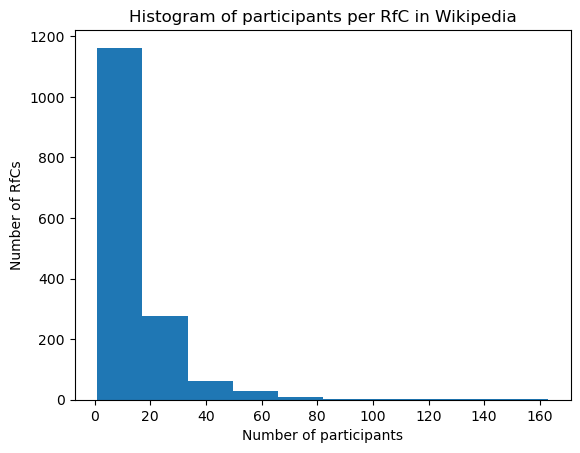

In [11]:
# merge the dataframes on rfc_id
merged_df = pd.merge(rfc_df, comment_df, on='rfc_id')
filtered_df = merged_df.loc[merged_df['project_x'] == 'wikipedia']
# count the number of unique participants per RfC and create a histogram
histogram_data = filtered_df.groupby('rfc_id')['user_name'].nunique()
plt.hist(histogram_data)
plt.xlabel('Number of participants')
plt.ylabel('Number of RfCs')
plt.title('Histogram of participants per RfC in Wikipedia')
plt.show()

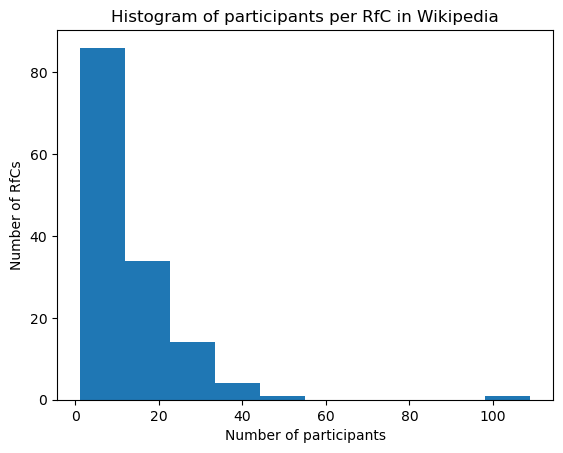

In [12]:
# merge the dataframes on rfc_id
merged_df = pd.merge(rfc_df, comment_df, on='rfc_id')
filtered_df = merged_df.loc[merged_df['project_x'] == 'wikidata']
# count the number of unique participants per RfC and create a histogram
histogram_data = filtered_df.groupby('rfc_id')['user_name'].nunique()
plt.hist(histogram_data)
plt.xlabel('Number of participants')
plt.ylabel('Number of RfCs')
plt.title('Histogram of participants per RfC in Wikipedia')
plt.show()

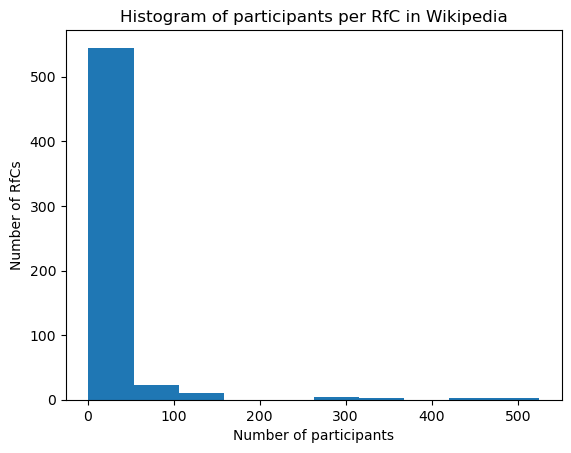

In [13]:
# merge the dataframes on rfc_id
merged_df = pd.merge(rfc_df, comment_df, on='rfc_id')
filtered_df = merged_df.loc[merged_df['project_x'] == 'meta.wikimedia']
# count the number of unique participants per RfC and create a histogram
histogram_data = filtered_df.groupby('rfc_id')['user_name'].nunique()
plt.hist(histogram_data)
plt.xlabel('Number of participants')
plt.ylabel('Number of RfCs')
plt.title('Histogram of participants per RfC in Wikipedia')
plt.show()

# Roles count per RfC

In [14]:
# Define the order of roles
roles = ['sysop', 'bureaucrat', 'user']

# Define a function to map the values in the dictionary to the roles
def map_permissions_to_role(permissions_dic):
    for role in roles:
        if role in permissions_dic.values():
            return role
    return None

# Apply the function to the permissions_dic column to create the new role column
users_df['role'] = users_df['permissions'].apply(map_permissions_to_role)

In [15]:
users_df.groupby("role").count()["user_id"]

role
bureaucrat      56
sysop          290
user          6822
Name: user_id, dtype: int64

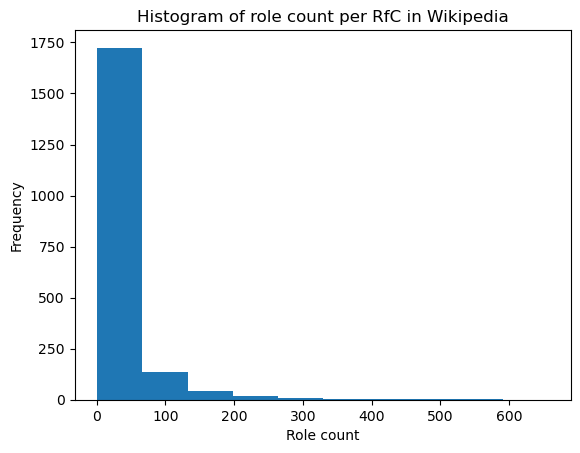

In [16]:
# Join the dataframes together
merged = comment_df.merge(users_df, on='user_name').merge(rfc_df, on='rfc_id')

filtered_df = merged.loc[merged_df['project_x'] == 'wikipedia']

# Count the number of roles per RfC
role_counts = filtered_df.groupby('rfc_id')['role'].value_counts()

# Create a histogram of role counts per RfC
role_counts.plot(kind='hist', bins=10)
plt.xlabel('Role count')
plt.title('Histogram of role count per RfC in Wikipedia')
plt.ylabel('Frequency')
plt.show()

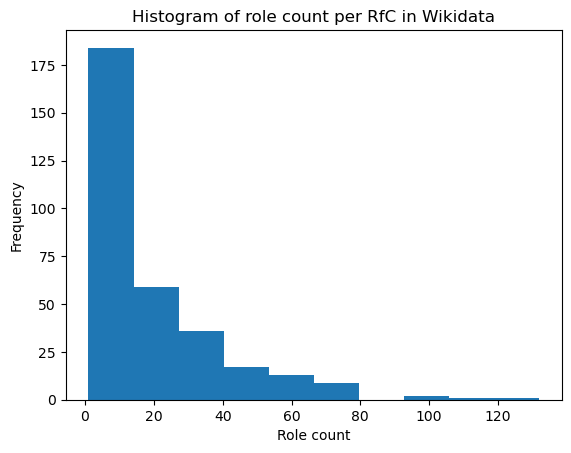

In [17]:
# Join the dataframes together
merged = comment_df.merge(users_df, on='user_name').merge(rfc_df, on='rfc_id')

filtered_df = merged.loc[merged_df['project_x'] == 'wikidata']

# Count the number of roles per RfC
role_counts = filtered_df.groupby('rfc_id')['role'].value_counts()

# Create a histogram of role counts per RfC
role_counts.plot(kind='hist', bins=10)
plt.xlabel('Role count')
plt.title('Histogram of role count per RfC in Wikidata')
plt.ylabel('Frequency')
plt.show()

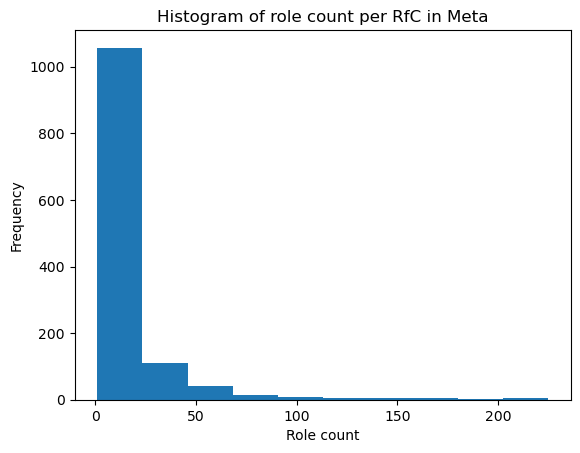

In [18]:
# Join the dataframes together
merged = comment_df.merge(users_df, on='user_name').merge(rfc_df, on='rfc_id')

filtered_df = merged.loc[merged_df['project_x'] == 'meta.wikimedia']

# Count the number of roles per RfC
role_counts = filtered_df.groupby('rfc_id')['role'].value_counts()

# Create a histogram of role counts per RfC
role_counts.plot(kind='hist', bins=10)  
plt.xlabel('Role count')
plt.title('Histogram of role count per RfC in Meta')
plt.ylabel('Frequency')
plt.show()

# Diversity of RfC groups

In [19]:
#Add total_editcount to user
# List of keys to sum editcounts for
keys_to_sum = ['wikipedia_project_sum','wikidatawiki','metawiki']

# Define a function to extract the desired editcounts from a dictionary
def extract_editcounts(editcount_dict, keys):
    return sum(editcount_dict.get(key) for key in keys)

# Apply the function to each row of the dataframe and sum up the results
users_df['total_editcount'] = users_df['editcount'].apply(extract_editcounts, args=(keys_to_sum,))


In [20]:
merged_df = comment_df.merge(users_df, on='user_name')

In [21]:
# group the dataframe by 'rfc_id'
grouped = merged_df.groupby('rfc_id')

# define the function to calculate Hill number-based diversity measures for each group
def hill_diversity(group):
    # calculate the proportions of each user role, mean account age, and mean edit count in the group
    role_proportions = group['role'].value_counts(normalize=True)
    age_proportions = group['account_age'] / group['account_age'].sum()
    edit_proportions = group['total_editcount'] / group['total_editcount'].sum()

    # add a small value to the proportions to prevent division by zero
    epsilon = 1e-10
    role_proportions = role_proportions + epsilon
    age_proportions = age_proportions + epsilon
    edit_proportions = edit_proportions + epsilon
    
    

    # calculate the Hill number-based diversity measures for the user roles, account age, and edit count
    role_diversity = np.power(np.e, -(np.sum(np.multiply(role_proportions, np.log(role_proportions)))))
    age_diversity = np.power(np.e, -(np.sum(np.multiply(age_proportions, np.log(age_proportions)))))
    edit_diversity = np.power(np.e, -(np.sum(np.multiply(edit_proportions, np.log(edit_proportions)))))
    
    # return a dictionary with the diversity measures for user roles, account age, and edit count
    return {'role_diversity': role_diversity, 'age_diversity': age_diversity, 'edit_diversity': edit_diversity}

# apply the function to each group in the grouped dataframe for each q value
hill_diversity_df = pd.DataFrame(grouped.apply(hill_diversity))

In [22]:
rfc_df = rfc_df.merge(hill_diversity_df, on='rfc_id')

In [23]:
# use apply and lambda to extract dictionary values to columns
rfc_df[['role_diversity', 'age_diversity', 'edit_diversity']] = rfc_df[0].apply(lambda x: pd.Series({'role_diversity': x['role_diversity'], 'age_diversity': x['age_diversity'], 'edit_diversity': x['edit_diversity']}))

# drop the original dictionary column
rfc_df = rfc_df.drop(0, axis=1)

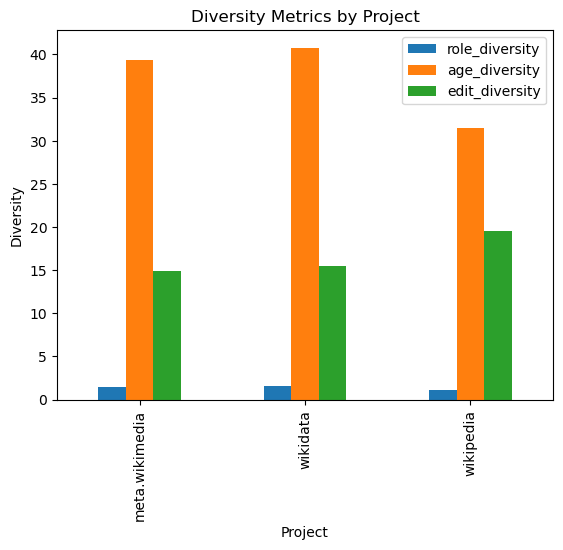

In [24]:
# group the DataFrame by project and calculate the mean of each diversity metric
filtered_df = rfc_df.filter(['project', 'role_diversity', 'age_diversity', 'edit_diversity'])
grouped_df = filtered_df.groupby('project').mean()

# plot the diversity metrics for each project
grouped_df.plot(kind='bar')
plt.title('Diversity Metrics by Project')
plt.xlabel('Project')
plt.ylabel('Diversity')
plt.show()

## Content

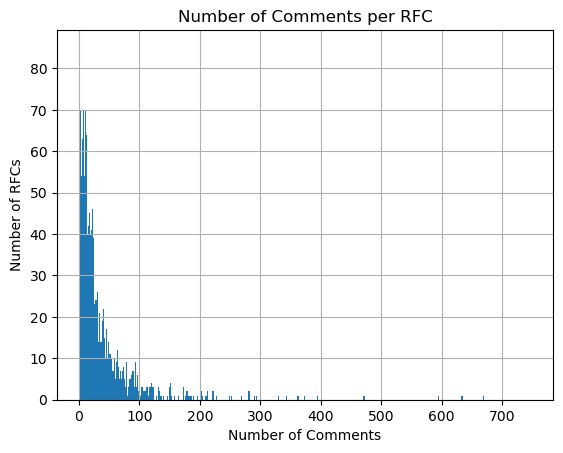

In [25]:
# count the number of comments per RFC and create a histogram
comments_per_rfc = comment_df.groupby('rfc_id').count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

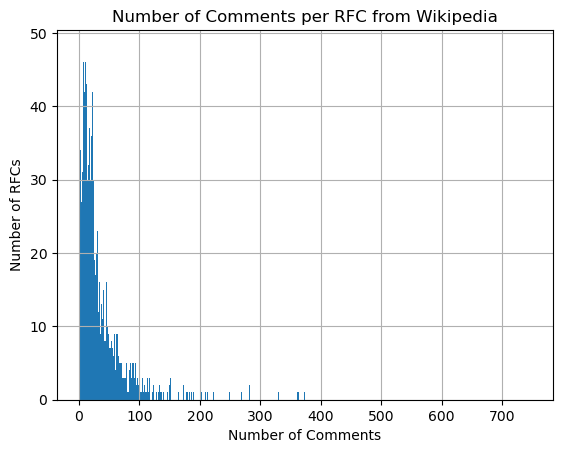

In [26]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'wikipedia']
comments_per_rfc = filtered_df.groupby('rfc_id').count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC from Wikipedia')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

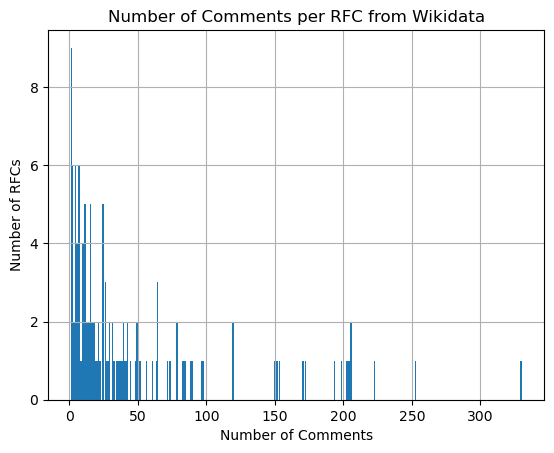

In [27]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'wikidata']
comments_per_rfc = filtered_df.groupby('rfc_id').count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC from Wikidata')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

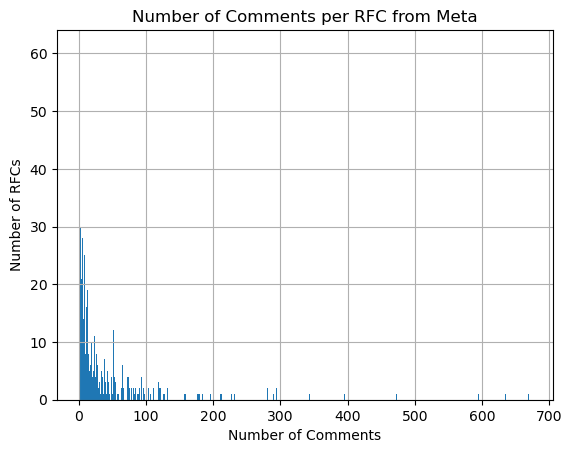

In [28]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'meta.wikimedia']
comments_per_rfc = filtered_df.groupby('rfc_id').count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC from Meta')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

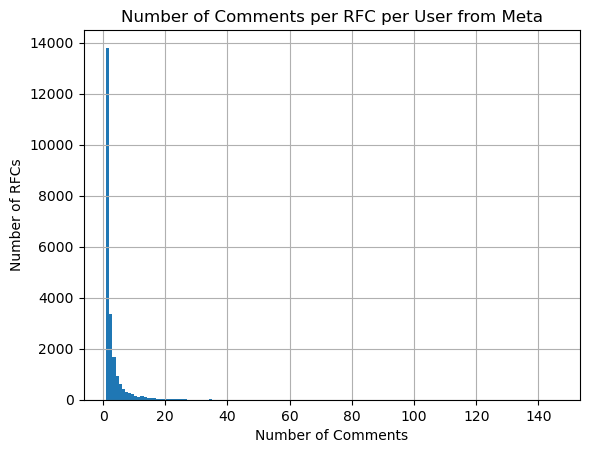

In [29]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'wikipedia']
comments_per_rfc = filtered_df.groupby(['rfc_id','user_name']).count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC per User from Meta')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

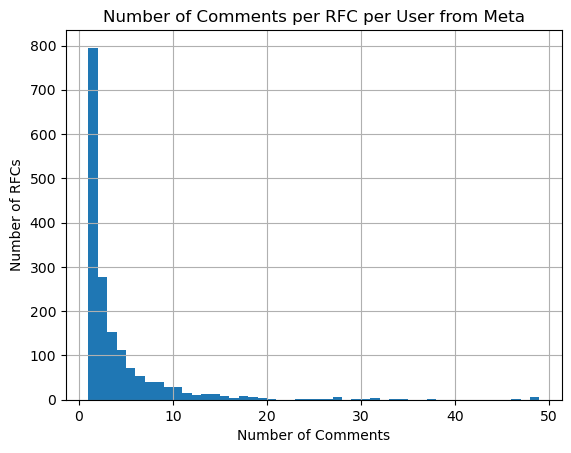

In [30]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'wikidata']
comments_per_rfc = filtered_df.groupby(['rfc_id','user_name']).count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC per User from Meta')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

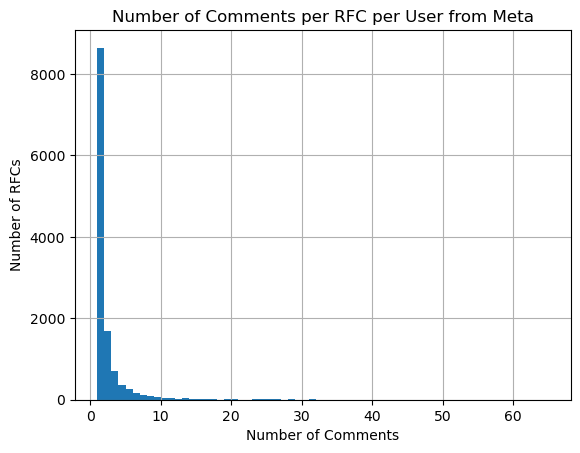

In [31]:
# count the number of comments per RFC from different projects and create a histogram
filtered_df = comment_df[comment_df['project'] == 'meta.wikimedia']
comments_per_rfc = filtered_df.groupby(['rfc_id','user_name']).count()['text']
comments_per_rfc.hist(bins=range(1, max(comments_per_rfc)+2))
plt.title('Number of Comments per RFC per User from Meta')
plt.xlabel('Number of Comments')
plt.ylabel('Number of RFCs')
plt.show()

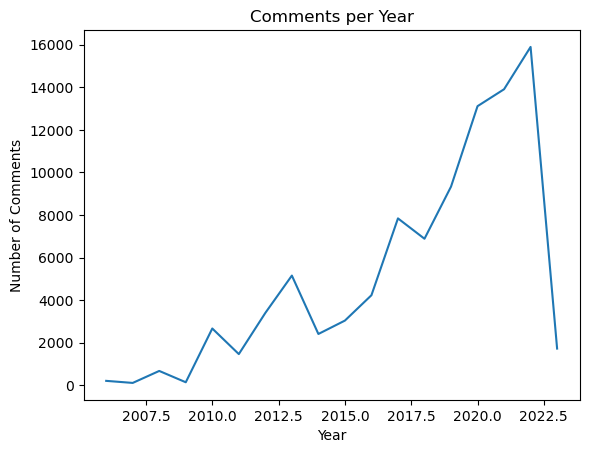

In [32]:
# convert date column to datetime format2
comment_df['date'] = pd.to_datetime(comment_df['date'])

# extract the year from date column and create a new column
comment_df['year'] = comment_df['date'].dt.year

# count the number of comments per year and create a new dataframe
count_df = comment_df.groupby('year').size().reset_index(name='counts')

# plot the count dataframe
plt.plot(count_df['year'], count_df['counts'])
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Comments per Year')
plt.show()

In [33]:
check_for_stance_df = comment_df
# preprocess the comment text column
check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')

/tmp/ipykernel_673/1606589629.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')


In [34]:
comment_df['support'] = check_for_stance_df['text'].str.startswith('support')
comment_df['oppose'] = check_for_stance_df['text'].str.startswith('oppose')
comment_df['comment'] = check_for_stance_df['text'].str.startswith('comment')

In [35]:
filtered_df = comment_df[comment_df['project'] == 'wikipedia']
# group the comments by RFC and count the number of True values in the support and oppose columns
counts_df = filtered_df.groupby('rfc_id')[['support', 'oppose', 'comment']].sum()

print(counts_df['support'].sum() / filtered_df['text'].count())
print(counts_df['oppose'].sum() / filtered_df['text'].count())
print(counts_df['comment'].sum() / filtered_df['text'].count())

0.05199295124611899
0.041721909876646805
0.018595284047998657


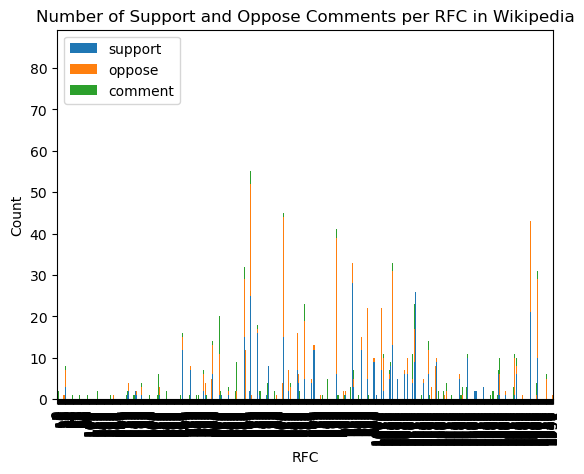

In [36]:
# create a bar chart of the counts
counts_df.plot(kind='bar', stacked=True)
plt.title('Number of Support and Oppose Comments per RFC in Wikipedia')
plt.xlabel('RFC')
plt.ylabel('Count')
plt.show()

In [37]:
filtered_df = comment_df[comment_df['project'] == 'wikidata']
# group the comments by RFC and count the number of True values in the support and oppose columns
counts_df = filtered_df.groupby('rfc_id')[['support', 'oppose', 'comment']].sum()

print(counts_df['support'].sum() / filtered_df['text'].count())
print(counts_df['oppose'].sum() / filtered_df['text'].count())
print(counts_df['comment'].sum() / filtered_df['text'].count())

0.0017597184450487923
0.0006398976163813789
0.018717005279155336


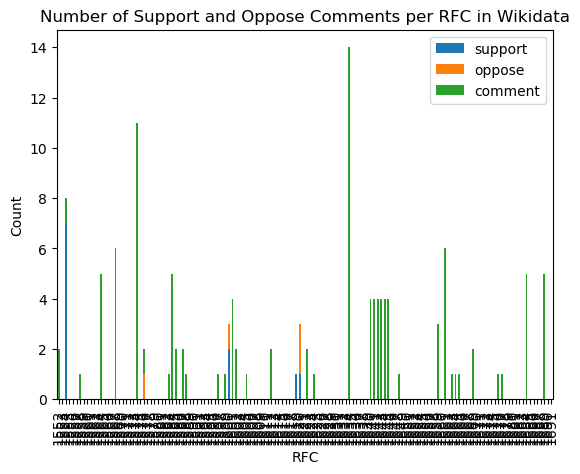

In [38]:
# create a bar chart of the counts
counts_df.plot(kind='bar', stacked=True)
plt.title('Number of Support and Oppose Comments per RFC in Wikidata')
plt.xlabel('RFC')
plt.ylabel('Count')
plt.show()

In [39]:
filtered_df = comment_df[comment_df['project'] == 'meta.wikimedia']
# group the comments by RFC and count the number of True values in the support and oppose columns
counts_df = filtered_df.groupby('rfc_id')[['support', 'oppose', 'comment']].sum()

print(counts_df['support'].sum() / filtered_df['text'].count())
print(counts_df['oppose'].sum() / filtered_df['text'].count())
print(counts_df['comment'].sum() / filtered_df['text'].count())

0.021074176553083426
0.004434673843004965
0.0022741917143615205


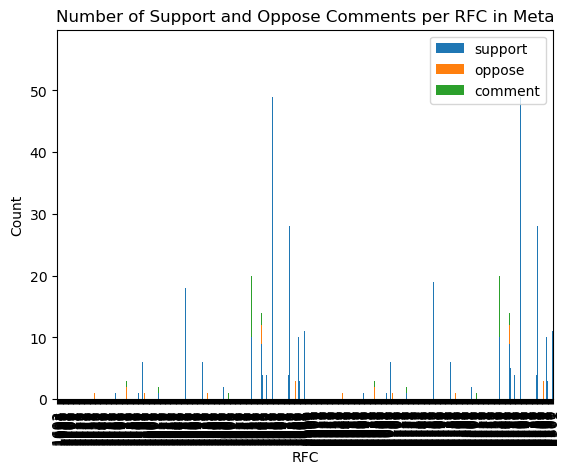

In [40]:
# create a bar chart of the counts
counts_df.plot(kind='bar', stacked=True)
plt.title('Number of Support and Oppose Comments per RFC in Meta')
plt.xlabel('RFC')
plt.ylabel('Count')
plt.show()

## Text Comparison

In [42]:
grouped = comment_df.groupby('project')
# create a dictionary of dataframes, with one dataframe for each unique value in the "class" column
dfs = {name: group for name, group in grouped}

# access each dataframe using its corresponding key
df_wikipedia_text = dfs['wikipedia']['text'].tolist()
df_wikidata_text = dfs['wikidata']['text'].tolist()
df_meta_text = dfs['meta.wikimedia']['text'].tolist()
# download the stopwords data if you haven't already
nltk.download('stopwords')

# get the set of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dylan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def remove_punctuation(txt):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
def clean_text(txt):
    """Removes punctuation, changes to lowercase, removes
        stopwords, removes "animal" and "crossing", and
        calculates word frequencies.

    Parameters
    ----------
    txt : string
        A text string that you want to clean.

    Returns
    -------
    Words and frequencies
    """
    
    tmp = [remove_punctuation(t) for t in txt]
    tmp = [t.lower().split() for t in tmp]
    
    tmp = [[w for w in t if not w in stop_words]
              for t in tmp]
    tmp = [[w for w in t if not w in ['animal', 'crossing']]
                     for t in tmp]
    
    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return tmp

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


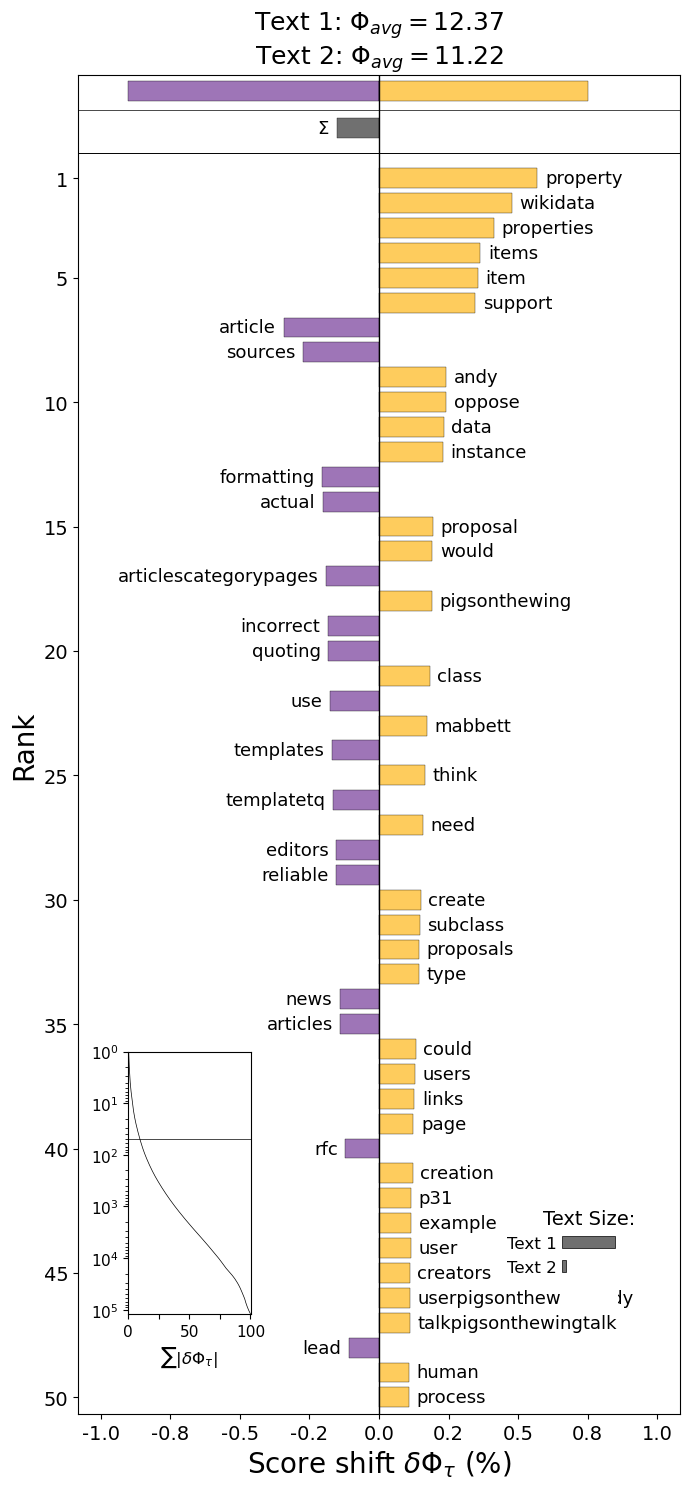

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.37\nText 2: $\\Phi_{avg}=$11.22'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [44]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_wikidata_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph() 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


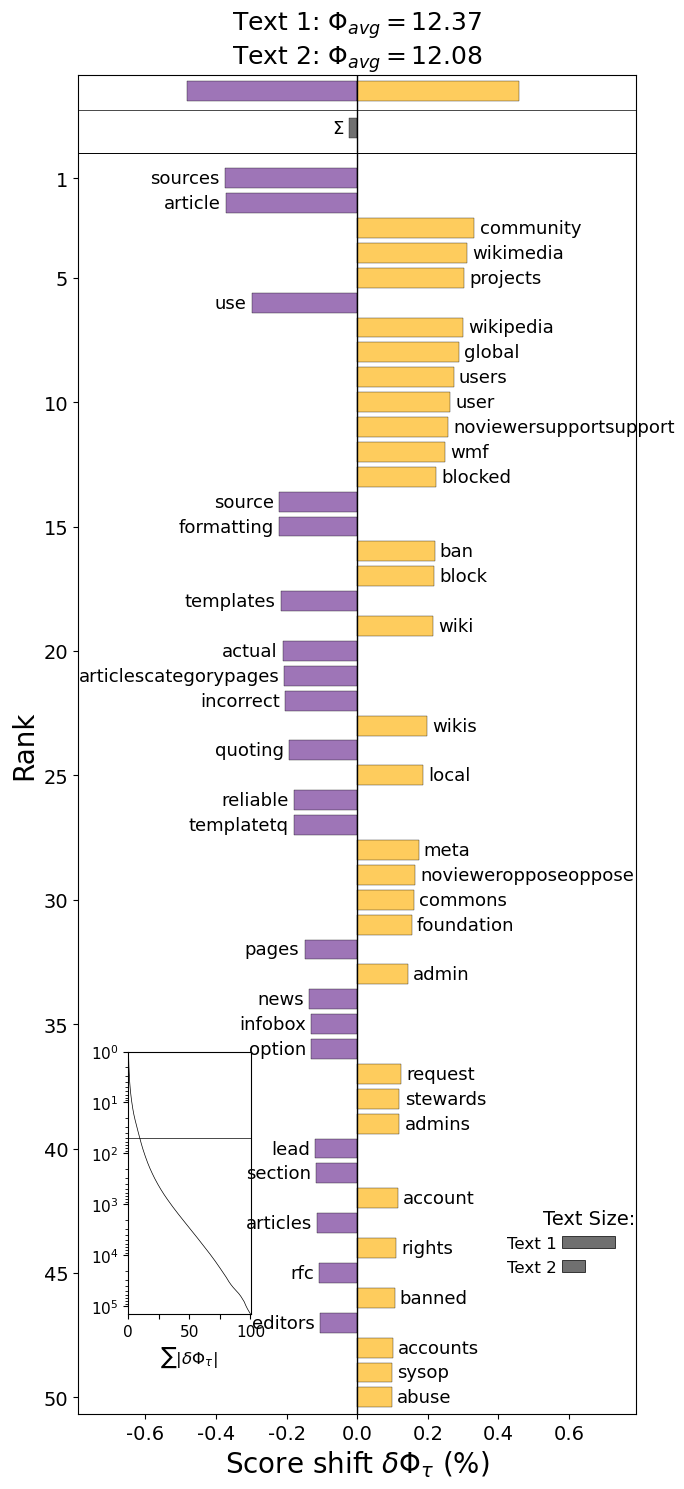

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.37\nText 2: $\\Phi_{avg}=$12.08'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [45]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_meta_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph() 